# ölksdjaföalksdjf

## TOC
- lkajsdfölakd
- asdflkasdjföl

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
import shap
from tqdm.notebook import tqdm


# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


In [89]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]-1
print(n_features)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(202878, 470)
469


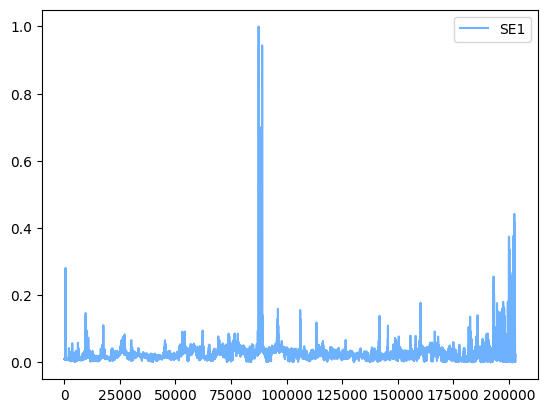

In [90]:
y = df['SE1']

plt.plot(y, color='#6db1ff', label='SE1')
plt.legend()

In [95]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 470)
(20287, 470)
(10143, 470)


In [96]:

train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df[:,1:], (train_df.shape[0], 1, train_df.shape[1]-1))
y_train = train_df[:,0]
print(y_train.shape)
X_val = np.reshape(val_df[:,1:], (val_df.shape[0], 1, val_df.shape[1]-1))
y_val = val_df[:,0]
X_test = np.reshape(test_df[:,1:], (test_df.shape[0], 1, test_df.shape[1]-1))
y_test = test_df[:,0]
# X_train = np.array(train_df.iloc[:,1:])
# y_train = np.array(train_df.iloc[:,0])
# X_val = np.array(val_df.iloc[:,1:])
# y_val = np.array(val_df.iloc[:,0])
# X_test = np.array(test_df.iloc[:,1:])
# y_test = np.array(test_df.iloc[:,0])
# sequence_length = 1
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print(X_test.shape)
# print(y_test.shape)
# # Define the sequence length for the LSTM model
# sequence_length = 10

# def create_sequences(df, sequence_length):
#     X = []
#     y = []
#     for i in range(len(df) - sequence_length):
#         X.append(df.iloc[i:i+sequence_length, 1:].values)
#         y.append(df.iloc[i+sequence_length, 0])
#     return np.array(X), np.array(y)


# X_train, y_train = create_sequences(train_df, sequence_length)
# X_val, y_val = create_sequences(val_df, sequence_length)
# X_test, y_test = create_sequences(test_df, sequence_length)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

(172448,)


In [97]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172448, 1, 469)
(172416, 1, 469)
(172416,)


(172416,)


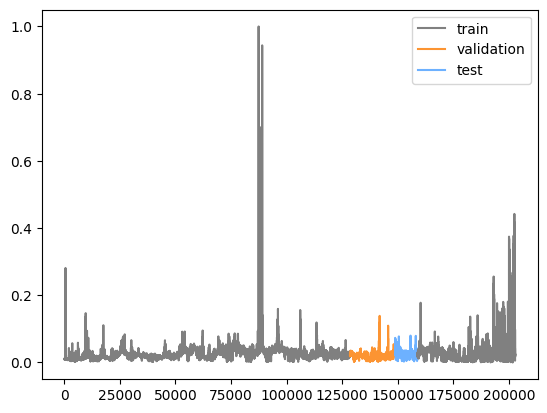

In [98]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey', label='train')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='#fc9432', label='validation')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='#6db1ff', label='test')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')
plt.legend()

In [99]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, input_shape=(None, n_features)),
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Normalization(),
    # tf.keras.layers.LSTM(32, input_shape=(sequence_length, n_features)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


In [100]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color='grey')
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color='#6db1ff')
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [101]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  # print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping, PlotLearning()])
  return history

# Data Analysis functions

feature_cutoff: Plot and calculate data cutoff based on mae impact

In [119]:
def feature_cutoff(df, baseline_mae, n_cols, iteration, cutoff = 0, prime = 0):
    # DISPLAY LSTM FEATURE IMPORTANCE
    df = pd.read_csv(iteration + '_feature_importance.csv', header=None, names=['feature','mae'])
    df = df.sort_values('mae')

    plt.figure(figsize=(10,20))
    print(n_cols)
    print(df.mae.shape)
    plt.barh(np.arange(n_cols + 1),df.mae, color='#6db1ff')
    plt.yticks(np.arange(n_cols + 1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,n_cols + 1))

    plt.plot([baseline_mae,baseline_mae],[-1,n_cols + 1], '--', color='orange',
                label=f'Baseline \nMAE={baseline_mae:.4f}')
    a_set_columns = [] 
    b_set_columns = []
    prime_set_columns = []

    df = df[df.feature != 'Baseline']

    if cutoff != 0:
        if cutoff == 1:
            cutoff = np.std(df).mae
        a_set_columns = df[df['mae'] >= baseline_mae - cutoff].feature
        b_set_columns = df[df['mae'] < baseline_mae - cutoff].feature
        plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color='red',
                    label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

    if prime != 0:
        if prime == 1:
            prime = np.std(df).mae
        prime_set_columns = df[df['mae'] > baseline_mae + cutoff].feature
        plt.plot([baseline_mae+cutoff,baseline_mae+cutoff],[-1,n_cols], '--', color='green',
                    label=f'Cutoff threshold\nMAE={baseline_mae+cutoff:.4f}')

    plt.xlabel(f'MAE with feature zeroed',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    return a_set_columns, b_set_columns, prime_set_columns

unique_average: Compute the average number of features that has low data uniqueness

In [103]:
def unique_average(data, n=25000):
# antal unika värden i snitt per feature
    list = []
    for i in range(data.shape[1]):
        list.append(data.iloc[:,i].nunique())
    list = pd.DataFrame(list)
    print('Share of columns that has less than n/25000 unique values')
    print(data.shape)
    print(list[list < n].count()/data.shape[1])
    plt.plot(list)

boxplot: Create a boxplot

In [104]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, columns.shape[0]//6))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    # rectangular box plot
    bplot1 = ax1.boxplot(data,
                        vert=False,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=columns)  # will be used to label x-ticks

    for patch in bplot1['boxes']:
        patch.set_facecolor('#6db1ff')
    plt.show()

feature_importance: Calculate feature importance

In [105]:
import os
def feature_importance(model, X, y, df, batch_size, iteration):
    COLS = list(df.columns[1:])
    n_cols = len(COLS)
    # n_cols = 5
    print('Computing LSTM feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y ))

    if not os.path.exists(iteration + '_feature_importance.csv'):
        results = []
        results.append({'feature':'BASELINE','mae':baseline_mae})           
        fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
        fi_df.to_csv(iteration + '_feature_importance.csv', index=False, header=False)
        for k in range(n_cols):
            # SHUFFLE FEATURE K
            save_col = X[:,:,k].copy()
            X[:,:,k] = np.zeros((X.shape[0],X.shape[1]))
                    
            # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
            oof_preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
            mae = np.mean(np.abs( oof_preds-y ))
            # results.append({'feature':COLS[k],'mae':mae})
            fi_df = pd.DataFrame([COLS[k], mae]).T
            fi_df.to_csv(iteration + '_feature_importance.csv', mode='a', index=False, header=False)
            X[:,:,k] = save_col
    
    return baseline_mae, n_cols


time_slice_mae_plot: plot the mae over batch time slices

In [106]:
def time_slice_mae_plot(model, X, y, batch_size):
    assert X.shape[0] % batch_size == 0
    n_batches = int(X.shape[0] / batch_size)
    print(n_batches)
    time_slice_mae = pd.DataFrame()
    for i in range(n_batches):
        data = X[i*batch_size:(i+1)*batch_size,:,:]
        preds = model.predict(data, verbose=0, batch_size=batch_size).squeeze() 
        time_slice_mae[i] = np.mean(np.abs(preds-y[i*batch_size:(i+1)*batch_size]))

    print(data[time_slice_mae > 0.0125])

    time_slice_mae.sort(reverse=True)
    plt.plot(time_slice_mae)




run_analysis_suite: run the data analysis suite based on the above functions

In [107]:
def run_analysis_suite(data, columns, n=25000):
    print("Data shape: ")
    print(data.shape)
    print('Unique average:')
    unique_average(data, n)
    boxplot(data, columns)

# Baseline

## Train Baseline

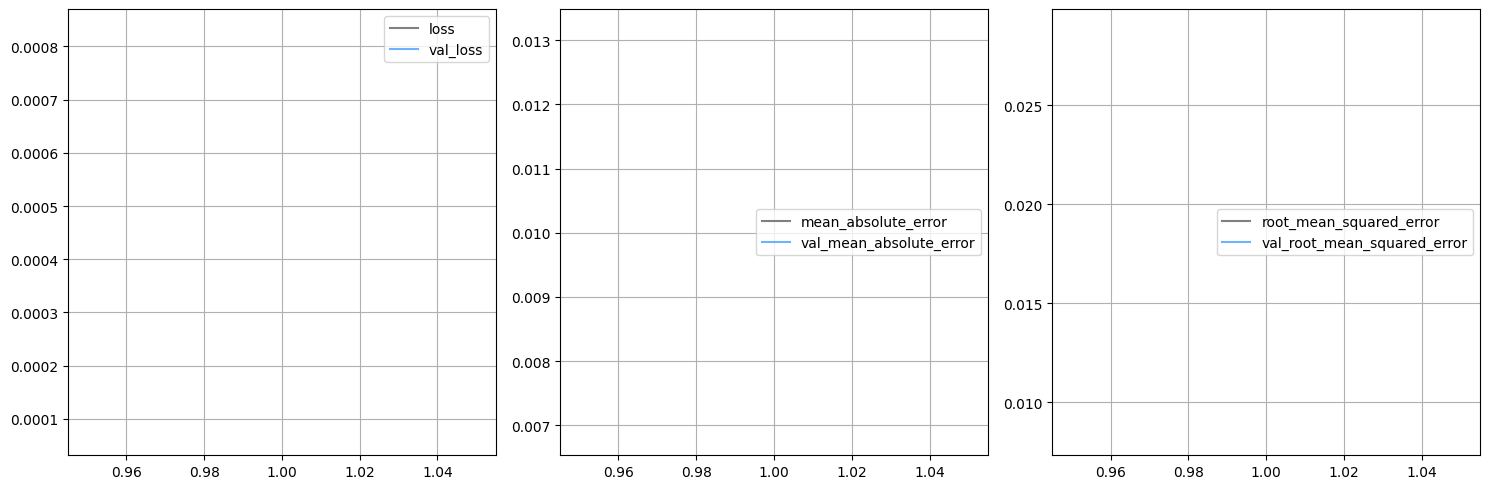

1347/1347 [==============================] - 14s 9ms/step - loss: 8.3235e-04 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0289 - val_loss: 6.9486e-05 - val_mean_absolute_error: 0.0068 - val_root_mean_squared_error: 0.0083


In [108]:
history = compile_and_fit(model, X_train, y_train)

## Baseline result/residuals

In [109]:
result = model.predict(X_test, batch_size=batch_size)

79/79 [==============================] - 1s 4ms/step


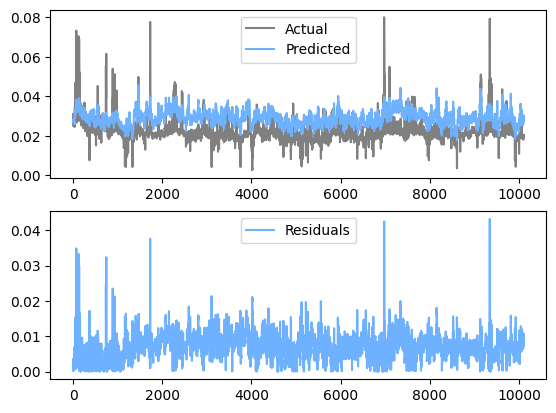

In [110]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(y_test, label='Actual', color='grey')
ax1.plot(result, label='Predicted', color='#6db1ff')
residuals = abs(np.subtract(np.array(result[:,0]), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color='#6db1ff')
ax2.legend()

## Baseline feature importance

[[[0.09969622 0.88160648 0.14133582 ... 0.05847953 0.17241379 0.10526316]]

 [[0.09969622 0.8841311  0.12818831 ... 0.05847953 0.11206897 0.26315789]]

 [[0.09969622 0.88388295 0.12073629 ... 0.05847953 0.09482759 0.26315789]]

 ...

 [[0.11122255 0.47296864 0.23283889 ... 0.29239766 0.14655172 0.05263158]]

 [[0.11122255 0.52964118 0.22583076 ... 0.29239766 0.19827586 0.05263158]]

 [[0.11122255 0.57989708 0.22336385 ... 0.23391813 0.13793103 0.05263158]]]
['Gas', 'Sveriges Förbrukning MWh', 'Summa Vindkraft', 'Summa Vattenkraft', 'Summa kärnkraft', 'Summa Värmekraft', 'Summa Ospecificerat', 'Summa Solkraft', 'Sveriges Produktion MWh', 'Import/Export', 'Bioenergy and renewable waste', 'Biomass and biogas', 'Differently categorized fossil fuels', 'Differently categorized hydro', 'Differently categorized natural gas', 'Differently categorized renewable energy sources', 'Differently categorized solar', 'Differently categorized wind', 'Fossil fuels', 'Hard coal', 'Hydro', 'Mixed fossil fu

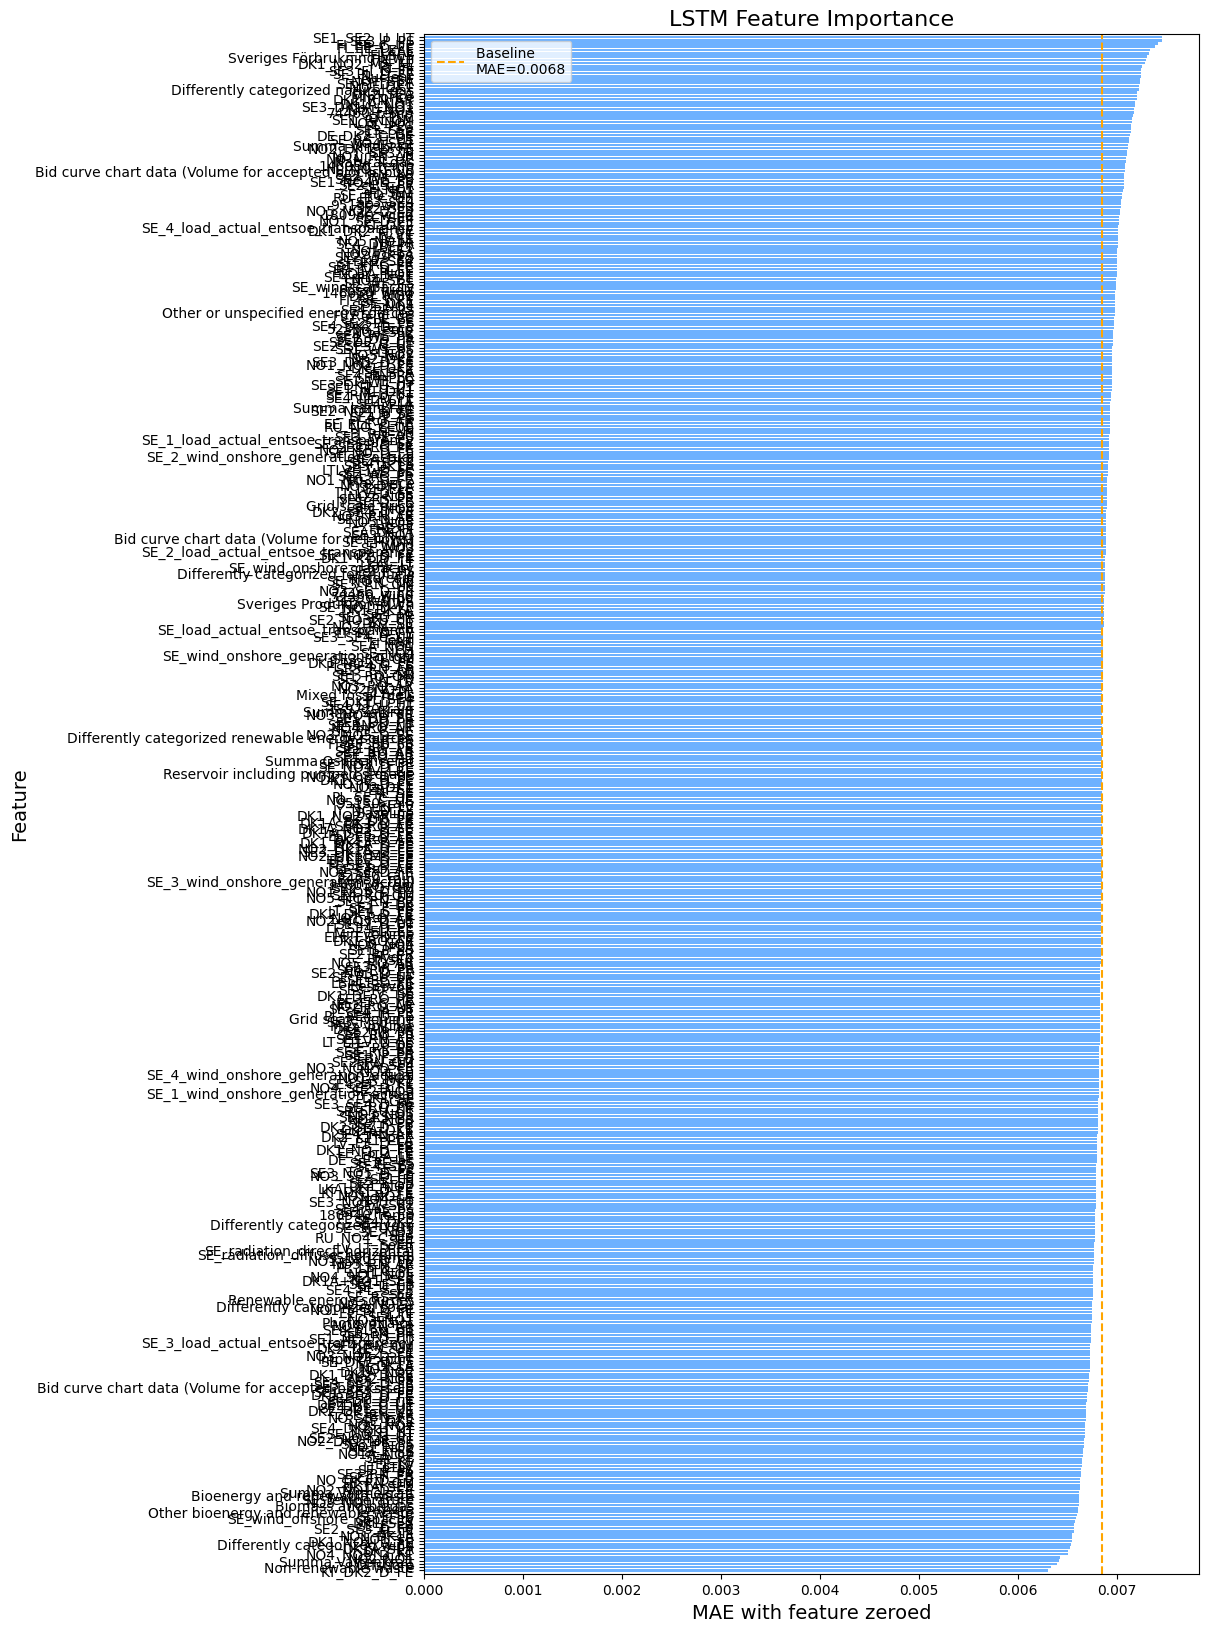

([], [], [])

In [111]:
baseline_mae, n_cols = feature_importance(model, X_val, y_val, df, batch_size, 'baseline')
feature_cutoff(df, baseline_mae, n_cols, 'baseline', cutoff = 0, prime = 0)

# Iteration 1

## Data analysis

### Feature Importance cutoff

469
(470,)


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


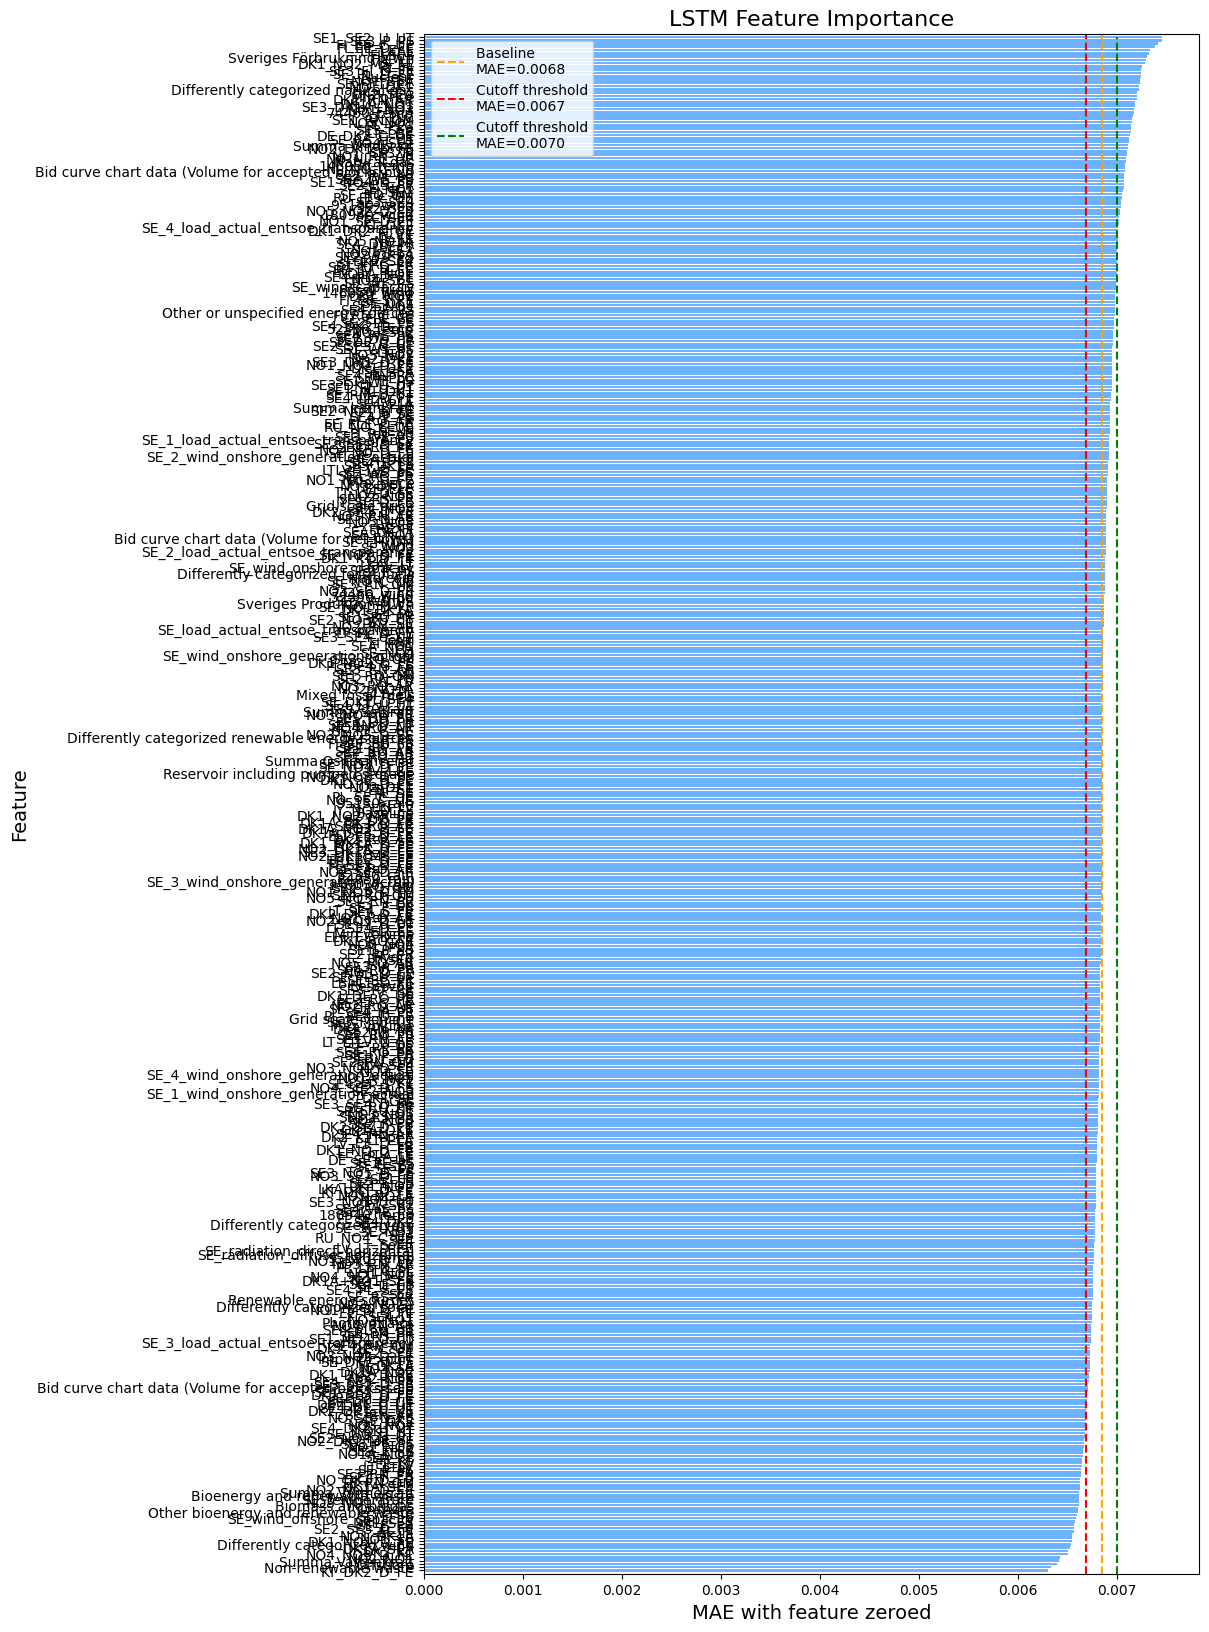

In [120]:
a_set_columns, b_set_columns, prime_set_columns = feature_cutoff(df, baseline_mae, n_cols, 'baseline', cutoff = 1, prime = 1)

#### B set

Data shape: 
(202878, 47)
Unique average:
Share of columns that has less than n/25000 unique values
(202878, 47)
0    0.510638
dtype: float64


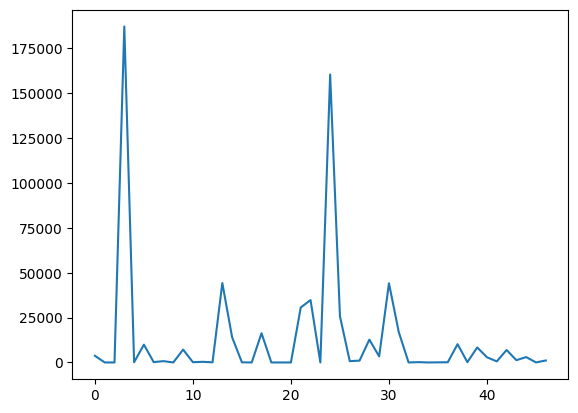

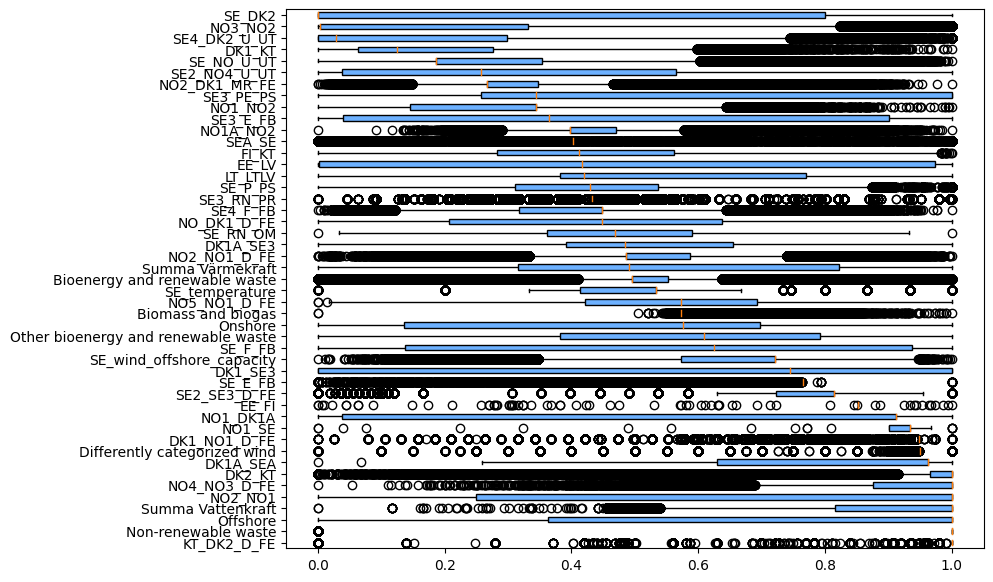

In [121]:
b_set = df[b_set_columns]
run_analysis_suite(b_set, b_set_columns)

#### A set

Data shape: 
(202878, 422)
Unique average:
Share of columns that has less than n/25000 unique values
(202878, 422)
0    0.822275
dtype: float64


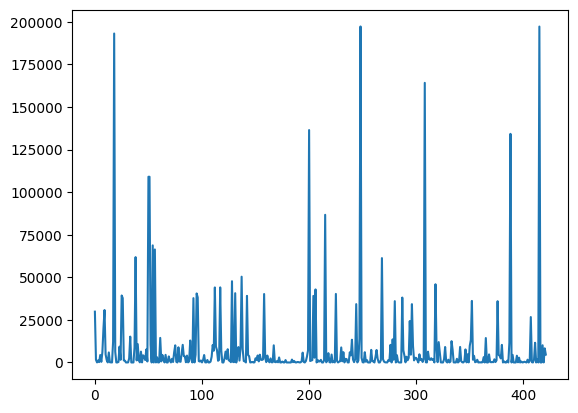

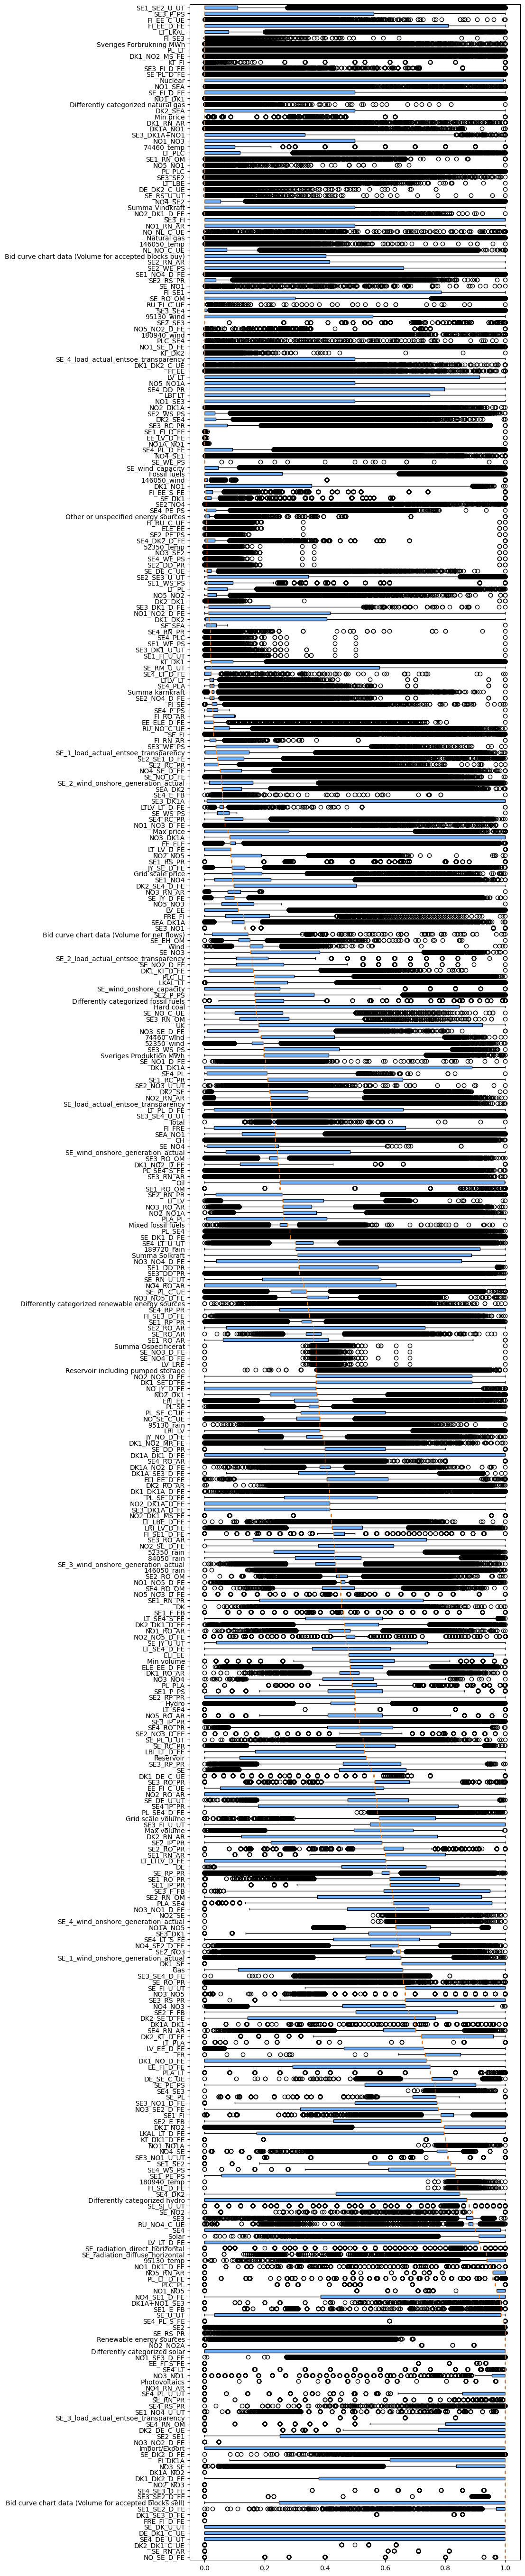

In [122]:
a_set = df[a_set_columns]
run_analysis_suite(a_set, a_set_columns)

#### Prime

Data shape: 
(202878, 65)
Unique average:
Share of columns that has less than n/25000 unique values
(202878, 65)
0    0.938462
dtype: float64


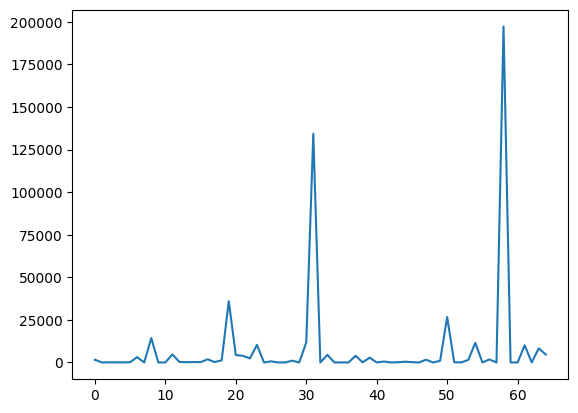

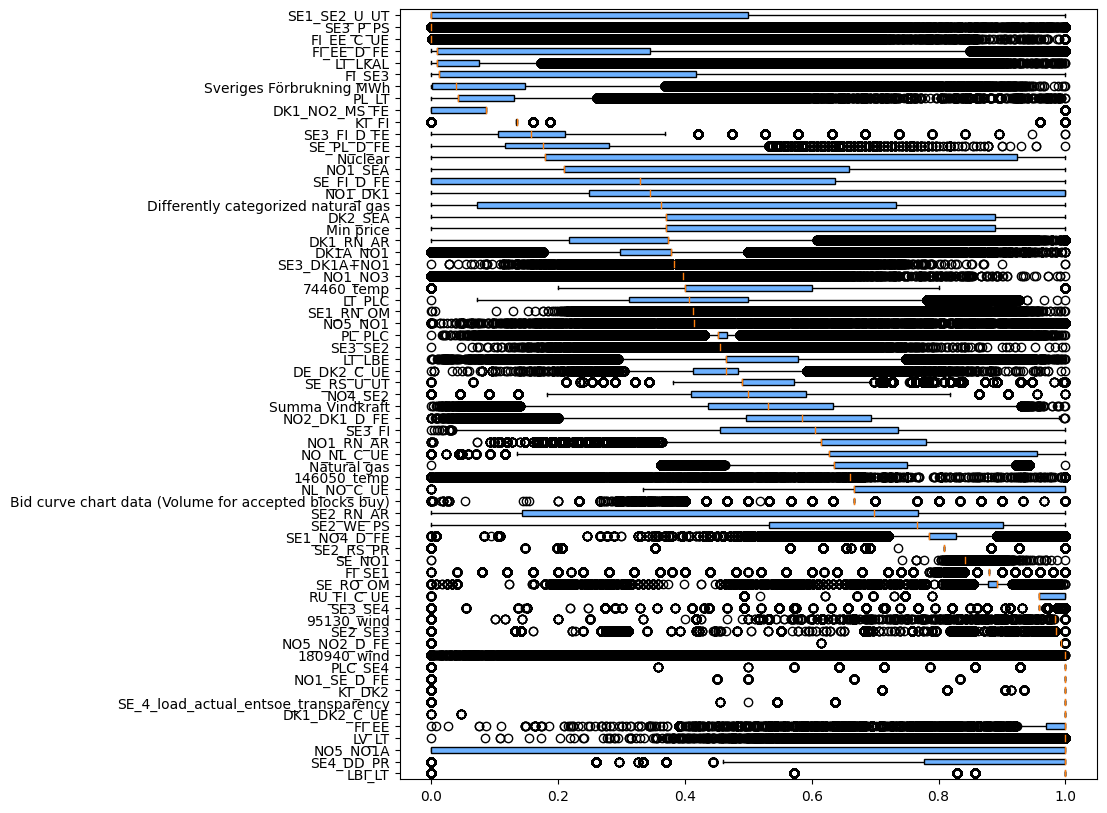

In [123]:
prime_set = df[prime_set_columns]
run_analysis_suite(prime_set, prime_set_columns)

### Time slice analysis

In [124]:
time_slice_mae_plot(model, X_train, y_train, batch_size)

1347


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


[]


AttributeError: 'DataFrame' object has no attribute 'sort'

In [ ]:
time_slice_mae = time_slice_mae_plot(model, X_val, y_val, batch_size)

158


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


[]


AttributeError: 'DataFrame' object has no attribute 'sort'